This notebook contains code for extracting box and turtlebot locations from an image.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

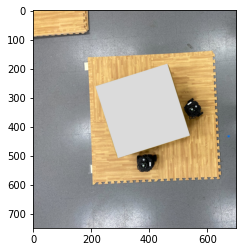

In [29]:
# Read image, downscale, and convert to grayscale
img = cv2.imread('mat_masked_box.png', cv2.IMREAD_COLOR)
r = 1000.0 / img.shape[1]
dim = (1000, int(img.shape[0] * r))
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
img = img[:, :700]
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.imshow(img)

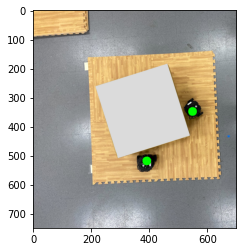

In [31]:
# First, let's get the turtlebot positions.
def get_turtlebot_positions_px(
    img,
    turtlebot_threshold=70,
):
    """Returns the pixel locations of the turtlebots.
    
    args:
        img: BGR image of turtlebots on a mat
        turtlebot_threshold: int between 0 and 255 setting the threshold
            for segmenting the turtlebots (which are black).
    returns:
        a list of (px, py) tuples of pixel locations for each turtlebot
        identified in the image.
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Blur it
    gray_blurred = cv2.blur(gray, (10, 10))
    
    # Threshold using the set value
    _, binary = cv2.threshold(gray_blurred, turtlebot_threshold, 255, cv2.THRESH_BINARY_INV)

    # Close up any holes
    kernel = np.ones((50, 50), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Find turtlebots using contours
    edged = cv2.Canny(binary, 30, 200)
    contours, hierarchy = cv2.findContours(
        edged, 
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_NONE
    )

    # Get the centers
    centers = []
    for c in contours:
        # compute the center of the contour
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        centers.append((cX, cY))
        
    return centers


draw_img = img.copy()
centers = get_turtlebot_positions_px(img, 70)
for cX, cY in centers:
    cv2.circle(draw_img, (cX, cY), 15, (0, 255, 0), -1)

plt.imshow(draw_img)

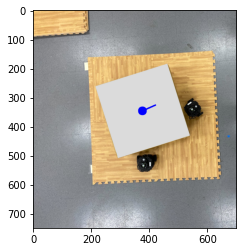

In [33]:
# Now let's see if we can detect the box
def get_box_pose_px(
    img,
    box_position_estimate,
    box_threshold=200,
):
    """Returns the pixel locations and radian angle of the box.
    
    If multiple contours are identified, chooses the one
    closest to the estimate.
    
    args:
        img: BGR image of box (with white/gray top) on a mat
        box_position_estimate: (px, py) guess of box position in pixels
        box_threshold: int between 0 and 255 setting the threshold
            for segmenting the box (which is light).
    returns:
        a tuple of (px, py, theta), where px and py are the pixel x and y
        locations of the box and theta is the angle of the box in radians
    """
    # (easier since I've decided to put paper on the top)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_blurred = cv2.blur(gray, (10, 10))

    # Threshold
    _, binary = cv2.threshold(gray_blurred, 200, 255, cv2.THRESH_BINARY)
    # Close up any holes
    kernel = np.ones((50, 50), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    edged = cv2.Canny(binary, 30, 200)
    contours, hierarchy = cv2.findContours(
        edged, 
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_NONE
    )

    # Get the center and orientation of the contour closest to the
    # estimated box position
    best_contour_distance = float('inf')
    best_contour_center = None
    best_contour_orientation = None
    for c in contours:
        # compute the center of the contour
        M = cv2.moments(c)
        cX = M["m10"] / M["m00"]
        cY = M["m01"] / M["m00"]
        
        # Compute the orientation. This has a bunch of steps.
        # See https://en.wikipedia.org/wiki/Image_moment#Examples_2
        # First, get the entries of the covariance matrix
        mu_prime_20 = M["mu20"] / M["m00"]
        mu_prime_02 = M["mu02"] / M["m00"]
        mu_prime_11 = M["mu11"] / M["m00"]

        # Then use the magic formula for angle (from wikipedia)
        theta = 0.5 * np.arctan(2 * mu_prime_11 / (mu_prime_20 - mu_prime_02))
        # This gives the angle of the eigenvalue of the intensity covariance,
        # which we can interpret as the largest axis of the contour. For a square,
        # this is 45 degrees off from the orientation of the sides of the box
        theta -= np.pi / 4.0
        
        # Check if this matches the estimate, and save it if so
        estimate_px, estimate_py = box_position_estimate
        distance_to_estimate = np.sqrt((cX - estimate_px) ** 2 + (cY - estimate_py) ** 2)
        if distance_to_estimate < best_contour_distance:
            best_contour_center = (int(cX), int(cY))
            best_contour_orientation = theta
    
    return best_contour_center, best_contour_orientation

draw_img = img.copy()
center, theta = get_box_pose_px(img, (img.shape[0] // 2, img.shape[1] // 2), 200)

# Draw center
cv2.circle(draw_img, (center[0], center[1]), 15, (0, 0, 255), -1)

# Draw line to indicate orientation
line_start = (cX, cY)
line_length = 50
line_end = (cX + int(line_length * np.cos(theta)), cY + int(line_length * np.sin(theta)), )
cv2.line(draw_img, line_start, line_end, (0, 0, 255), 4)

plt.imshow(draw_img)

In [39]:
import time
total_time = 0.0
N = 1000
for i in range(N):
    start = time.perf_counter()
    center, theta = get_box_pose_px(img, (img.shape[0] // 2, img.shape[1] // 2), 200)
    centers = get_turtlebot_positions_px(img, 70)
    end = time.perf_counter()
    total_time += end - start
print(f"Time per call: {total_time / N} s (avg. over {N} trials)")
print(f"Achievable framerate (processing time only): {N / total_time} fps")

Time per call: 0.005924033999021049 s (avg. over 1000 trials)
Achievable framerate (processing time only): 168.80389278070498 fps
